### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Lecture 4

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

#### Load and process the dataset

In [ ]:
# Conditional check for unzipping
unzip = False

# Unzip the 'animals.zip' file if the 'unzip' flag is True
if unzip:
    !unzip animals.zip

# Unzip the 'items.zip' file if the 'unzip' flag is True
    !unzip items.zip

In [ ]:
def load_images_from_folder(folder):
    images = []

    # Iterate through files in the specified folder
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        img = tfkl.Resizing(224, 224)(img)

        if img is not None:
            images.append(img)

    return np.array(images)

# Load images from the 'animals/' folder
animals_path = 'animals/'
animals = load_images_from_folder(animals_path)

# Load images from the 'items/' folder
items_path = 'items/'
items = load_images_from_folder(items_path)

In [ ]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(items[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create subplots for displaying animals
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(animals[i], 0, 255))  # Display clipped animal images
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Concatenate 'animals' and 'items' arrays along axis 0
X = np.concatenate([animals, items], axis=0)

# Create labels: 1 for 'animals', 0 for 'items'
y = np.concatenate([np.ones(len(animals)), np.zeros(len(items))], axis=0)

y = tfk.utils.to_categorical(y,len(np.unique(y)))

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.25, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (120, 224, 224, 3), y_train shape: (120, 2)
X_val shape: (60, 224, 224, 3), y_val shape: (60, 2)
X_test shape: (60, 224, 224, 3), y_test shape: (60, 2)


In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 1000

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (224, 224, 3), Output Shape: (2,), Batch Size: 32, Epochs: 1000


In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True, mode='auto'),
]

#### Train without augmentation

In [ ]:
def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 relu0 (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 mp0 (MaxPooling2D)          (None, 112, 112, 32)      0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 relu1 (ReLU)                (None, 112, 112, 64)      0         
                                                                 
 mp1 (MaxPooling2D)          (None, 56, 56, 64)        0       

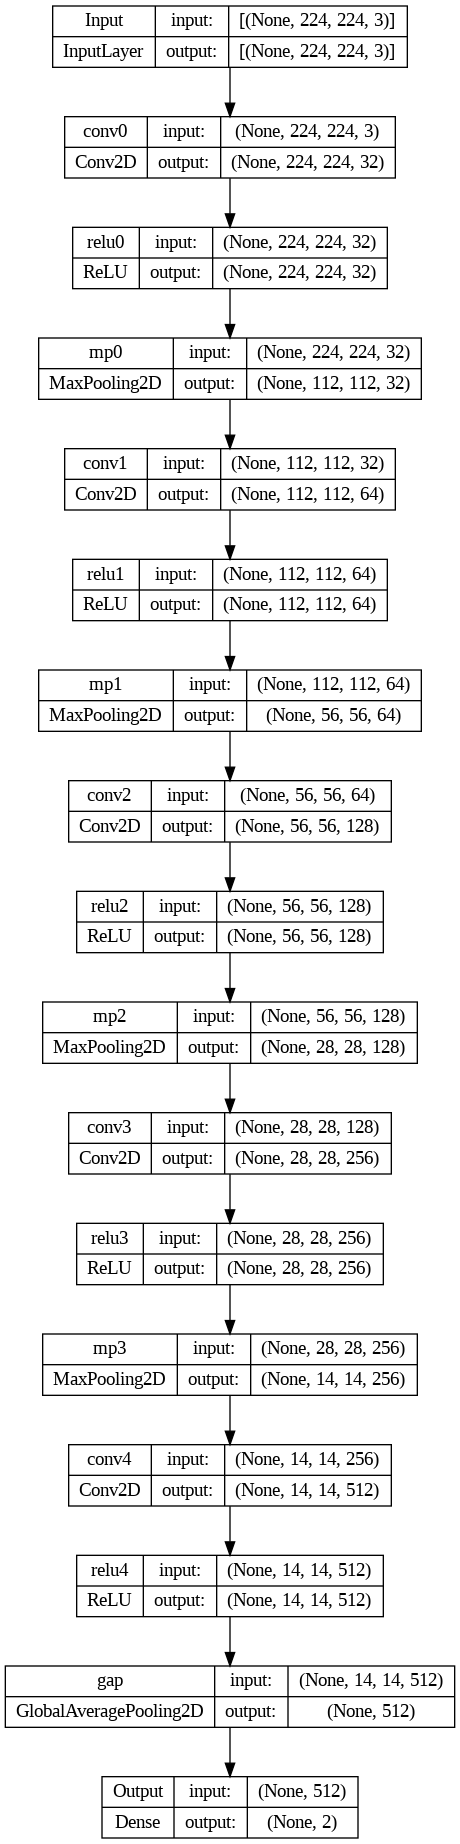

In [ ]:
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/1000
4/4 [==============================] - 15s 744ms/step - loss: 0.7006 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.5167
Epoch 2/1000
4/4 [==============================] - 0s 100ms/step - loss: 0.6941 - accuracy: 0.5083 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/1000
4/4 [==============================] - 0s 121ms/step - loss: 0.6924 - accuracy: 0.5500 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 4/1000
4/4 [==============================] - 0s 94ms/step - loss: 0.6919 - accuracy: 0.5000 - val_loss: 0.6839 - val_accuracy: 0.5000
Epoch 5/1000
4/4 [==============================] - 0s 103ms/step - loss: 0.6819 - accuracy: 0.5167 - val_loss: 0.6770 - val_accuracy: 0.5333
Epoch 6/1000
4/4 [==============================] - 0s 99ms/step - loss: 0.6796 - accuracy: 0.5250 - val_loss: 0.6670 - val_accuracy: 0.5500
Epoch 7/1000
4/4 [==============================] - 0s 100ms/step - loss: 0.6550 - accuracy: 0.6000 - val_loss: 0.6600 - val_accuracy: 0.6000
Epoch 8

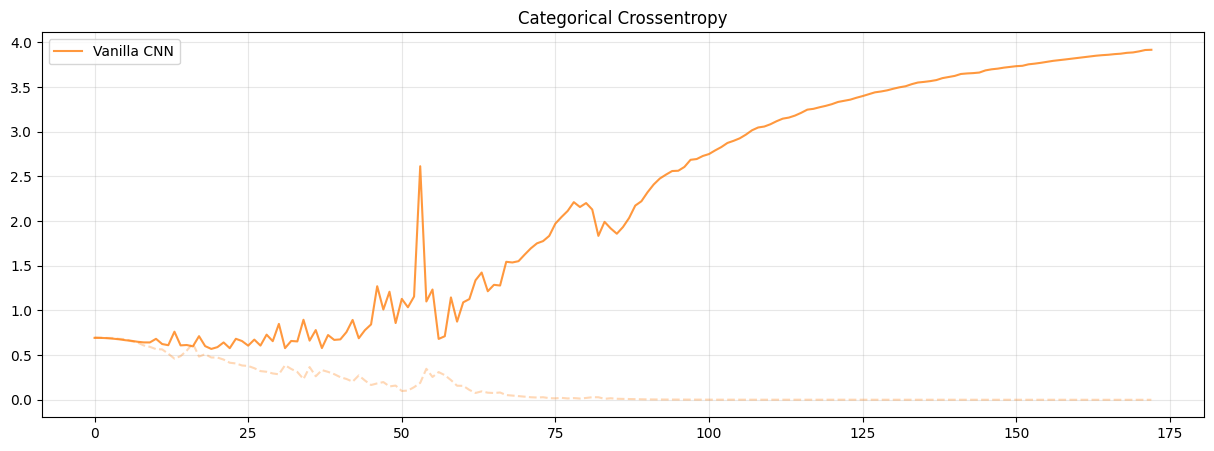

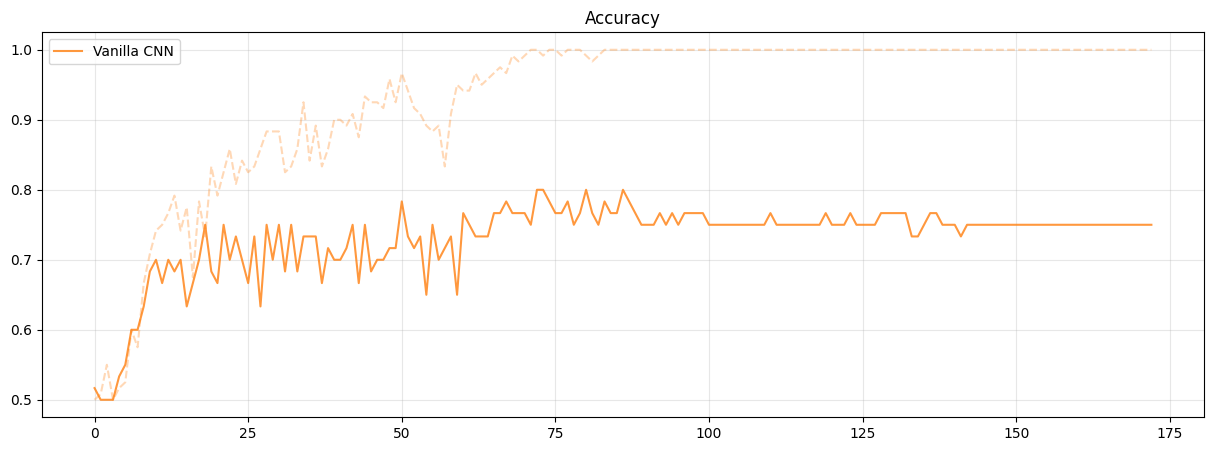

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Augmentation

In [ ]:
num_img = 10 # Images to plot

#### Random Flip

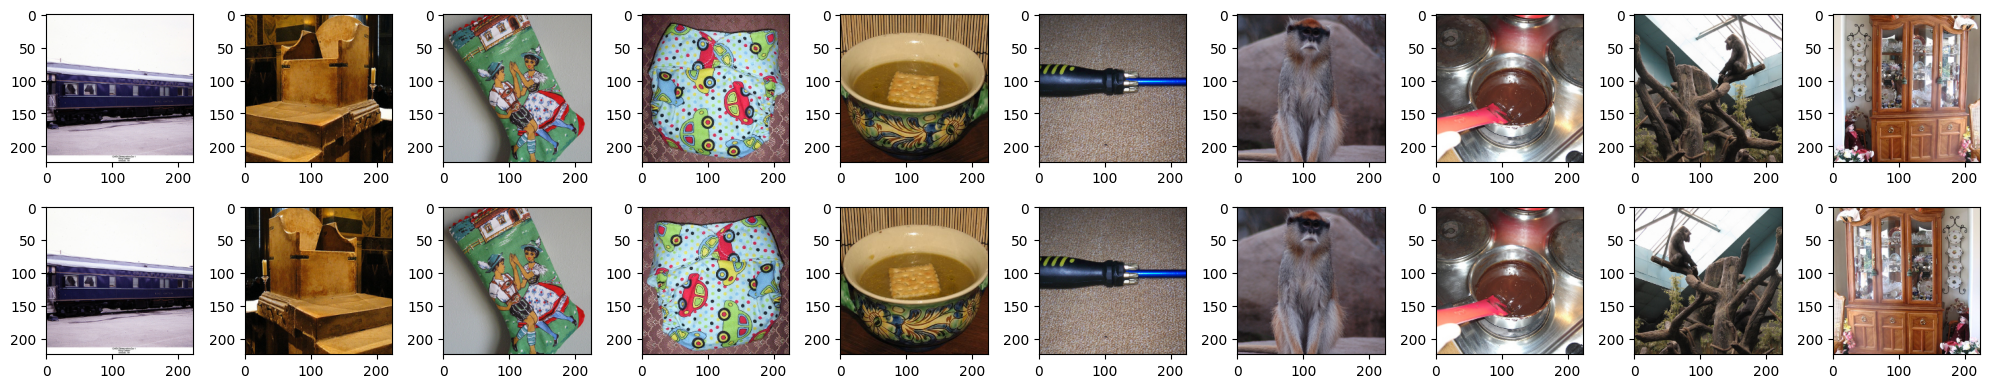

In [ ]:
flip = tf.keras.Sequential([
  tfkl.RandomFlip("horizontal"),
])

X_train_flip = flip(X_train)

fig, axes = plt.subplots(2, num_img, figsize=(20,4))
for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(X_train[i])
    ax = axes[1,i%num_img]
    ax.imshow(X_train_flip[i])
plt.tight_layout()
plt.show()

#### Random Translation

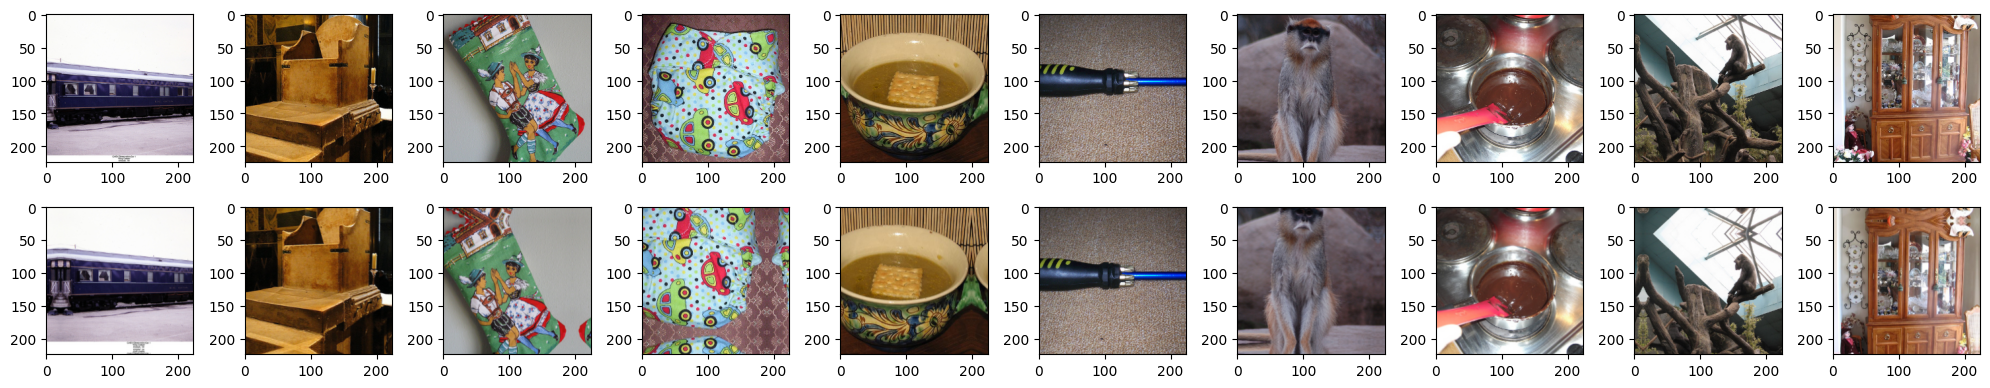

In [ ]:
translation = tf.keras.Sequential([
  tfkl.RandomTranslation(0.2,0.2),
])

X_train_translation = translation(X_train)

fig, axes = plt.subplots(2, num_img, figsize=(20,4))
for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(X_train[i])
    ax = axes[1,i%num_img]
    ax.imshow(X_train_translation[i])
plt.tight_layout()
plt.show()

#### Random Rotation

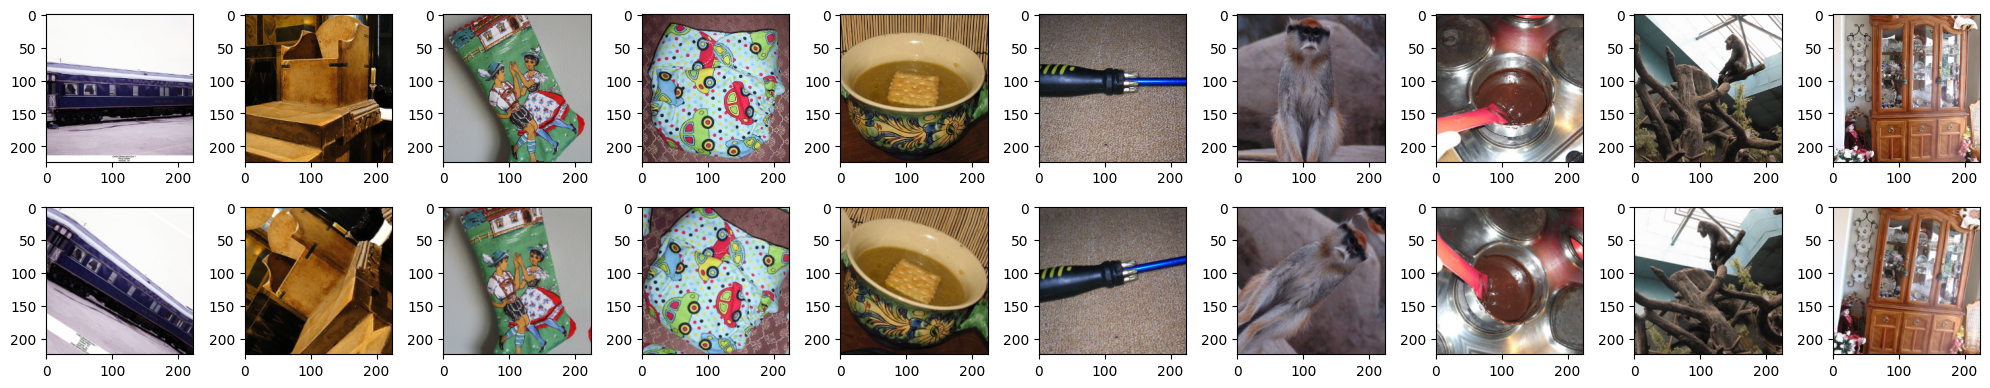

In [ ]:
rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.2),
])

X_train_rotation = rotation(X_train)

fig, axes = plt.subplots(2, num_img, figsize=(20,4))
for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(X_train[i])
    ax = axes[1,i%num_img]
    ax.imshow(X_train_rotation[i])
plt.tight_layout()
plt.show()

### Random Zoom

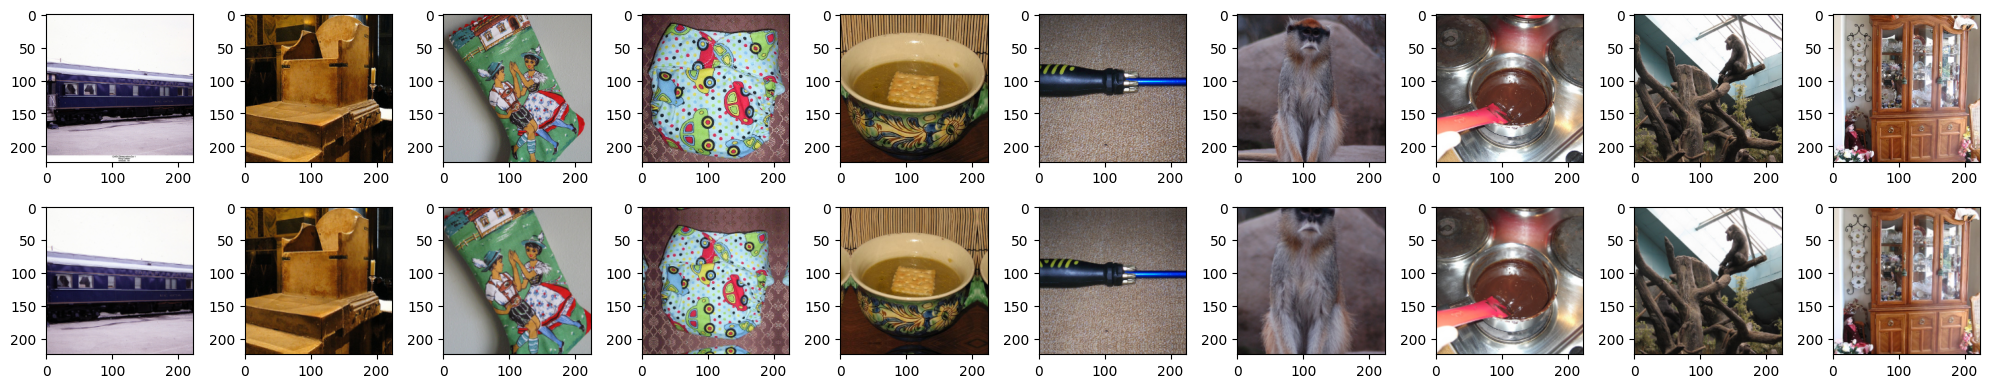

In [ ]:
zoom = tf.keras.Sequential([
  tfkl.RandomZoom(0.2),
])

X_train_zoom = zoom(X_train)

fig, axes = plt.subplots(2, num_img, figsize=(20,4))
for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(X_train[i])
    ax = axes[1,i%num_img]
    ax.imshow(X_train_zoom[i])
plt.tight_layout()
plt.show()

### Random Brightness

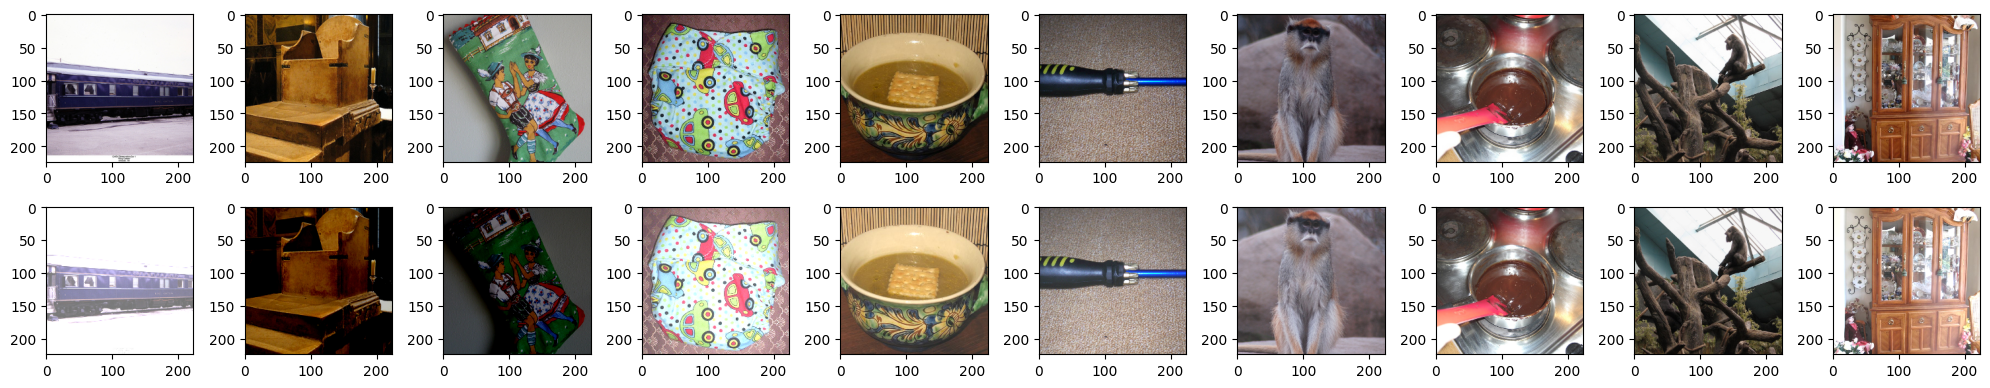

In [ ]:
rotation = tf.keras.Sequential([
  tfkl.RandomBrightness(0.5, value_range=(0,1)),
])

X_train_rotation = rotation(X_train)

fig, axes = plt.subplots(2, num_img, figsize=(20,4))
for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(X_train[i])
    ax = axes[1,i%num_img]
    ax.imshow(X_train_rotation[i])
plt.tight_layout()
plt.show()

### Random Contrast

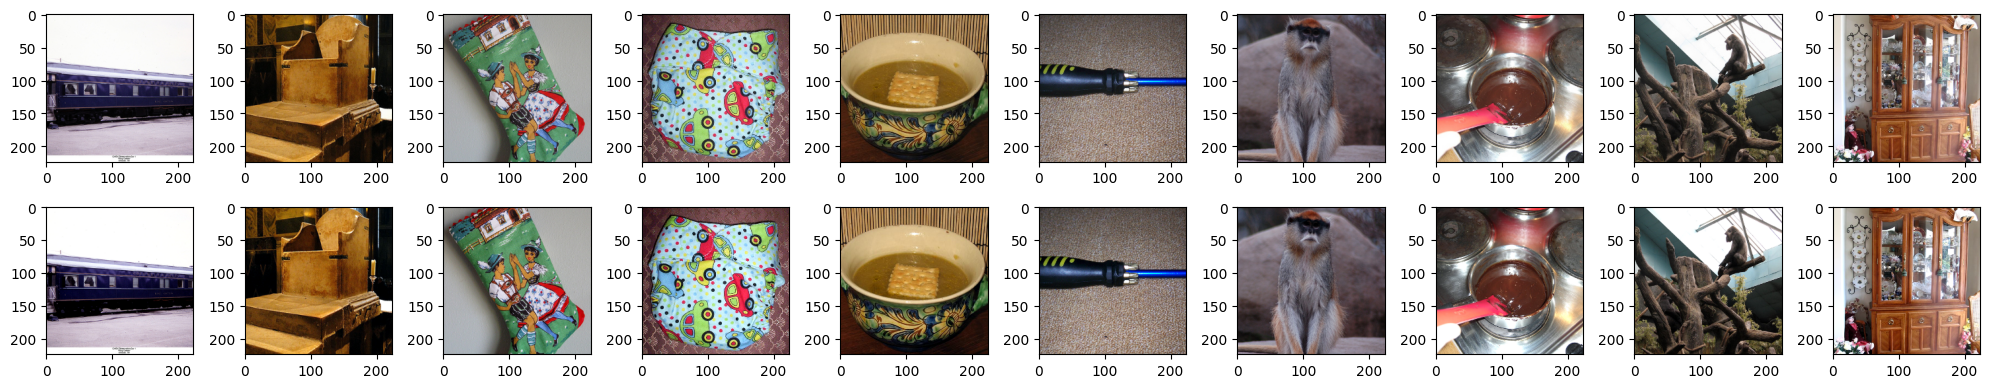

In [ ]:
contrast = tf.keras.Sequential([
  tfkl.RandomContrast(0.75),
])

X_train_contrast = contrast(X_train)

fig, axes = plt.subplots(2, num_img, figsize=(20,4))
for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(X_train[i])
    ax = axes[1,i%num_img]
    ax.imshow(np.clip(X_train_contrast[i], 0, 1))
plt.tight_layout()
plt.show()

#### Model with augmentation

In [ ]:
def build_model_with_augmentation(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomTranslation(0.2,0.2),
    ], name='preprocessing')

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(preprocessing)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 preprocessing (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv0 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 relu0 (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 mp0 (MaxPooling2D)          (None, 112, 112, 32)      0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 relu1 (ReLU)                (None, 112, 112, 64)      0       

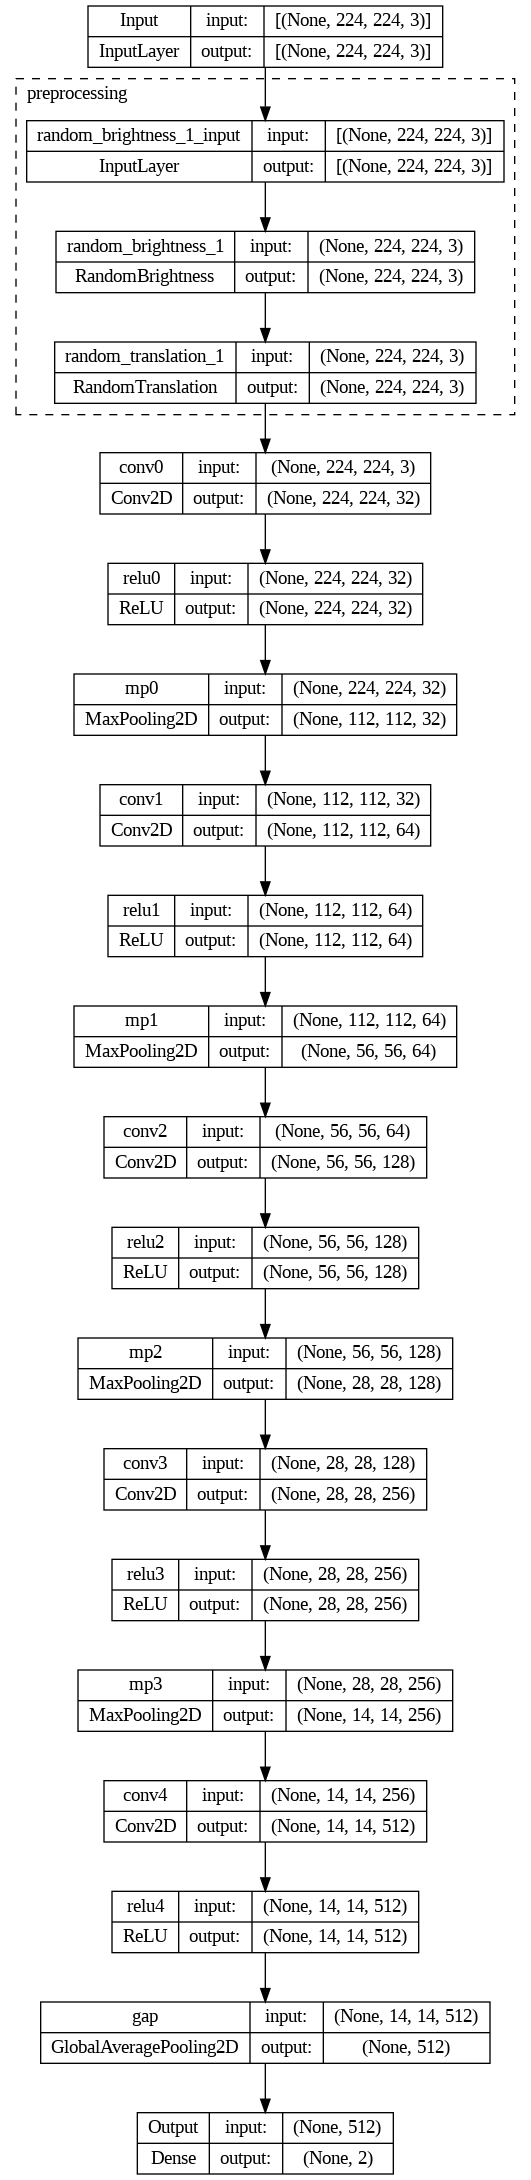

In [ ]:
augmented_model = build_model_with_augmentation()
augmented_model.summary()
tfk.utils.plot_model(augmented_model, expand_nested=True, show_shapes=True)

In [ ]:
# Train the model
aug_history = augmented_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/1000
4/4 [==============================] - 2s 194ms/step - loss: 0.7158 - accuracy: 0.5000 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/1000
4/4 [==============================] - 0s 82ms/step - loss: 0.6976 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.5000
Epoch 3/1000
4/4 [==============================] - 0s 82ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 4/1000
4/4 [==============================] - 0s 80ms/step - loss: 0.6930 - accuracy: 0.4750 - val_loss: 0.6914 - val_accuracy: 0.5167
Epoch 5/1000
4/4 [==============================] - 0s 84ms/step - loss: 0.6913 - accuracy: 0.4917 - val_loss: 0.6867 - val_accuracy: 0.5000
Epoch 6/1000
4/4 [==============================] - 0s 77ms/step - loss: 0.6929 - accuracy: 0.4917 - val_loss: 0.6796 - val_accuracy: 0.4833
Epoch 7/1000
4/4 [==============================] - 0s 94ms/step - loss: 0.6857 - accuracy: 0.5167 - val_loss: 0.6766 - val_accuracy: 0.6333
Epoch 8/1000

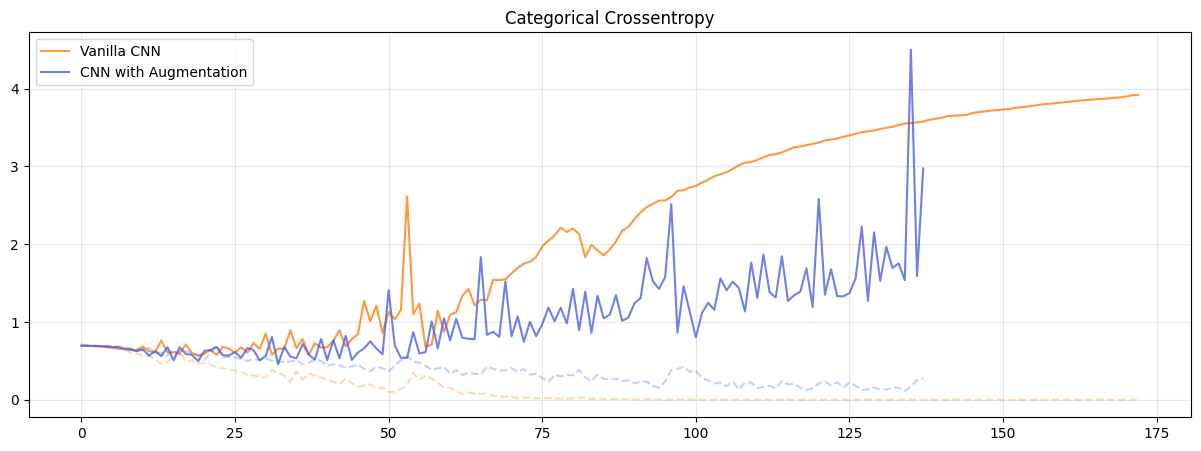

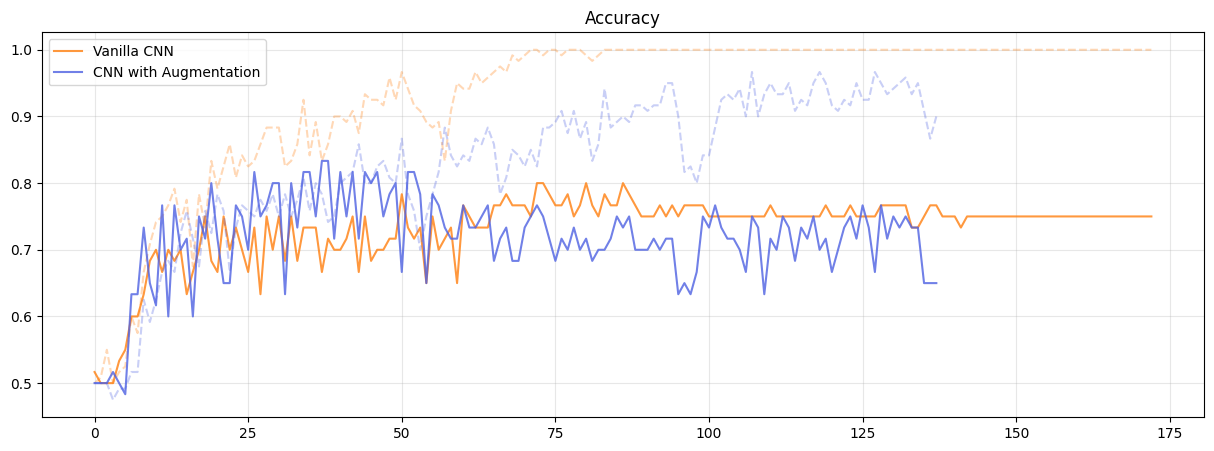

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.plot(aug_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(aug_history['val_loss'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.plot(aug_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(aug_history['val_accuracy'], label='CNN with Augmentation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
augmented_model.save('augmented_model')

### Make inference

In [ ]:
# del augmented_model
augmented_model = tfk.models.load_model('augmented_model')

In [ ]:
# Predict labels for the entire test set
predictions = augmented_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (60, 2)


Accuracy: 0.7167
Precision: 0.7291
Recall: 0.7167
F1: 0.7128


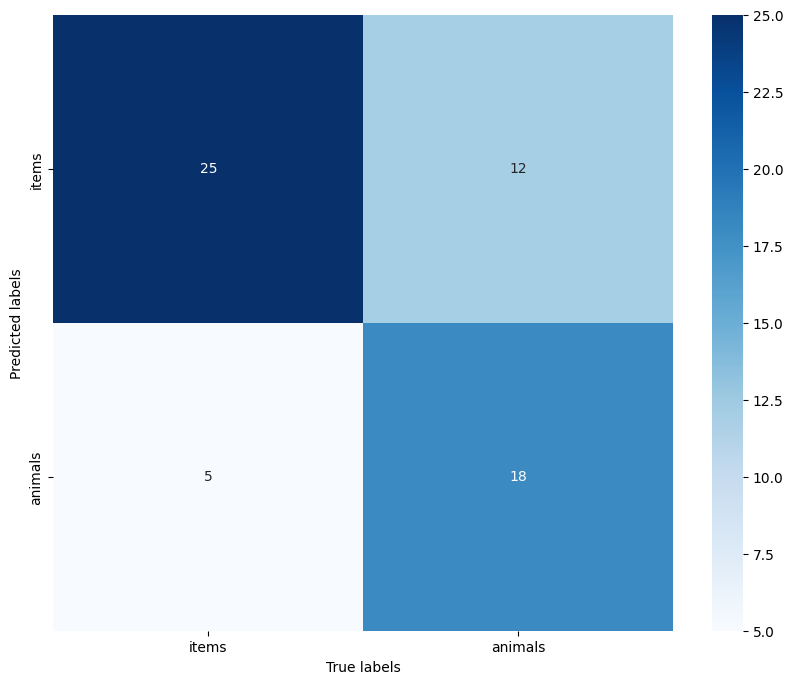

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('items','animals')), yticklabels=list(('items','animals')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### [EXTRA] Image retrieval

In [ ]:
embedding = tfk.Sequential(augmented_model.layers[:-1])
embedding.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 conv0 (Conv2D)              (None, 224, 224, 32)      896       
                                                                 
 relu0 (ReLU)                (None, 224, 224, 32)      0         
                                                                 
 mp0 (MaxPooling2D)          (None, 112, 112, 32)      0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 64)      18496     
                                                                 
 relu1 (ReLU)                (None, 112, 112, 64)      0         
                                                                 
 mp1 (MaxPooling2D)          (None, 56, 56, 64)       

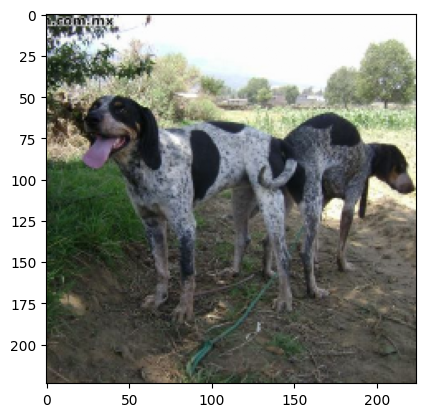

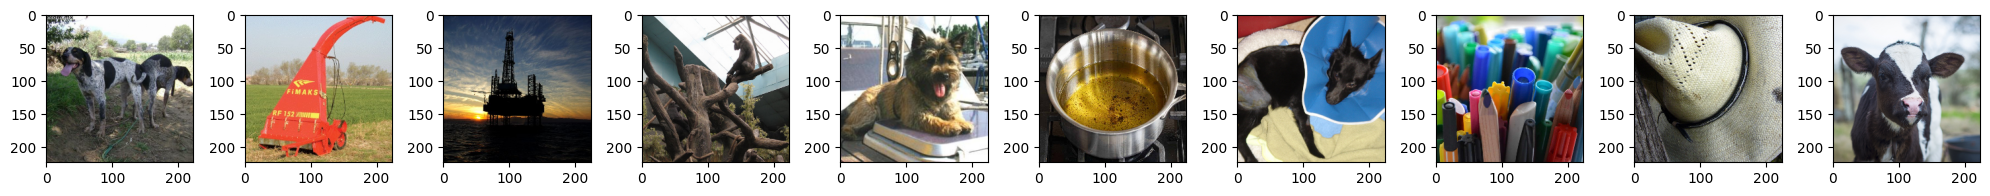

In [ ]:
index = 0

image = np.expand_dims(X[index],axis=0)
image_features = embedding.predict(image,verbose=0)
plt.imshow(X[index])
plt.show()

dataset_features = embedding.predict(X,batch_size=32,verbose=0)
distances = np.mean(np.square(dataset_features - image_features),axis=-1)
ordered_images = X[distances.argsort()]

# Inspect the data
num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(20,20))
for i in range(num_img):
    ax = axes[i%num_img]
    ax.imshow(ordered_images[i])
plt.tight_layout()
plt.show()

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*